In [1]:
%cd project/

/home/rapids/notebooks/project


In [3]:
%pip install -r "requirements.txt"

Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
   ---------------------------------------- 0.0/15.6 MB ? eta -:--:--
   -------------- ------------------------- 5.8/15.6 MB 32.0 MB/s eta 0:00:01
   -------------------------------------- - 14.9/15.6 MB 37.5 MB/s eta 0:00:01
   ---------------------------------------- 15.6/15.6 MB 39.2 MB/s eta 0:00:00
  Attempting uninstall: numpy
    Found existing installation: numpy 2.1.1
    Uninstalling numpy-2.1.1:
      Successfully uninstalled numpy-2.1.1
Note: you may need to restart the kernel to use updated packages.


In [2]:
import skmob
from skmob.utils.plot import plot_gdf
from skmob.tessellation import tilers
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import sys
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

np.set_printoptions(threshold=sys.maxsize)
pd.set_option('display.max_columns', 500)
pd.set_option('display.max_rows', 64)
plt.rcParams['figure.figsize'] = [10, 5]


In [3]:
def toAdj(fdf, tess):
    names = list(tess.tile_ID.values)
    adj = pd.DataFrame(columns=names, index = names)
    for i, row in enumerate(fdf.itertuples(), 1):
         adj.at[str(row.origin), str(row.destination)] = row.flow
    return adj

In [129]:
shape_file_land = gpd.read_file("./barriosCABA.geojson")

meters = 2612.61
tessellation = tilers.tiler.get("squared", meters=meters, base_shape=shape_file_land)
plot_gdf(tessellation, style_func_args={'fillColor':'gray', 'color':'black', 'opacity': 0.2}, zoom = 12, popup_features=['tile_ID']) 



In [82]:
%%time
df = pd.read_csv('./datasets/all_trips.csv')




df['start_date'] =  pd.to_datetime(df['fecha_origen_recorrido']).dt.strftime('%Y-%m-%d')
df['stop_date'] =  pd.to_datetime(df['fecha_destino_recorrido']).dt.strftime('%Y-%m-%d')
df = df[df['start_date'] == df['stop_date']]

df['date'] = df['start_date']
df.rename(columns={'lat_estacion_origen':'start_lat', 'long_estacion_origen':'start_lon', 'lat_estacion_destino':'end_lat', 'long_estacion_destino':'end_lon'}, inplace=True)
# df = df[['date','lat_estacion_origen', 'long_estacion_origen', 'lat_estacion_destino', 'long_estacion_destino']]
# df.columns = ['date','start_lat', 'start_lon', 'end_lat', 'end_lon']


df_start = df[['date', 'start_lat', 'start_lon']]
df_start['lat'] = df['start_lat']
df_start['lon'] = df['start_lon']
df_start['uid'] = df.index
df_start = df_start[['date', 'lat', 'lon', 'uid']]


df_end =  df[['date', 'end_lat', 'end_lon']]
df_end['lat'] = df['end_lat']
df_end['lon'] = df['end_lon']
df_end['uid'] = df.index
df_end = df_end[['date', 'lat', 'lon', 'uid']]


# Convertir las coordenadas de los viajes a un GeoDataFrame
gdf_start = gpd.GeoDataFrame(df_start, geometry=gpd.points_from_xy(df_start.lon, df_start.lat, crs="EPSG:4326"))

# Asignar cada viaje al mosaico correspondiente
gdf_start = gpd.sjoin(gdf_start, tessellation, how="left", predicate='within')
gdf_start = gdf_start.rename(columns={'tile_ID':'origin'})
gdf_start = gdf_start[['date', 'uid', 'origin']]

# Hacer lo mismo para las coordenadas de destino
gdf_end = gpd.GeoDataFrame(df_end, geometry=gpd.points_from_xy(df_end.lon, df_end.lat, crs="EPSG:4326"))
gdf_end = gpd.sjoin(gdf_end, tessellation, how="left", predicate='within')
gdf_end = gdf_end.rename(columns={'tile_ID':'destination'})
gdf_end = gdf_end[['date', 'uid', 'destination']]


# Unir los dos GeoDataFrames
gdf = gdf_start.merge(gdf_end, on=['date', 'uid'])

gdf['date'] = pd.to_datetime(gdf['date'])

# Separacion por dias
# data = data.groupby([data['date'].dt.year, data['date'].dt.isocalendar().week])
# data = gdf.groupby(['date', 'origin', 'destination']).size().reset_index(name='flow')
# data = data.groupby('date')

# Separacion por semanas
data = gdf
data['week_year'] = data['date'].dt.strftime('%U-%Y')
data = data.groupby(['week_year', 'origin', 'destination']).size().reset_index(name='flow')
data = data.groupby('week_year')

# for row,group in data:
#     p = os.path.join('./filtered/sem', "{}.csv".format(row))
#     group.to_csv(p, index=False)

CPU times: user 2min 39s, sys: 18.5 s, total: 2min 58s
Wall time: 3min 9s


In [96]:
data.get_group('01-2020').apply(lambda x: x['flow'], axis=1).size

1553

In [97]:
# get the week with the most flows
test = data.groups
max_v = 0
max_k = ''
for key in test.keys():
    group = data.get_group(key)
    flows = group.apply(lambda x: x['flow'], axis=1).size
    if flows > max_v:
        max_v = flows
        max_k = key
print(max_k, max_v, data.get_group(max_k))





38-2019 1728        week_year origin destination  flow
149849   38-2019      1           1   135
149850   38-2019      1          11     1
149851   38-2019      1          13     4
149852   38-2019      1          14    33
149853   38-2019      1          17     6
...          ...    ...         ...   ...
151572   38-2019      9          53    28
151573   38-2019      9          54    12
151574   38-2019      9          58     6
151575   38-2019      9          59     2
151576   38-2019      9           9    72

[1728 rows x 4 columns]


# From Tdf to Flow to AdjMatrix #

In [17]:
%%time
directory = './filtered/sem/'
i = 1
l = []

for filename in os.listdir(directory):
    
    base= os.path.basename(filename)
    name = os.path.splitext(base)[0]
    # print(i)
    
    df = pd.read_csv(directory+filename)
    tdf = skmob.TrajDataFrame(df, latitude='lat', longitude='lon', 
                                user_id='ind', datetime='date')

    

    # fdf = to_fdf(tdf, tessellation, self_loops=True)
    fdf = tdf.to_flowdataframe(tessellation, self_loops=True)

    adj = toAdj(fdf, tessellation)
    adj = adj.fillna(0)
    arr = adj.to_numpy()
    xy+=90
    # np.save("./matrices/adj/sem/" +name +'.npy', arr) 
    # i += 1


KeyError: 'datetime'

In [114]:
a = np.load("./matrices/adj/sem/38-2019.npy")
a

array([[   0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0],
       [   0,  135,    1,   11,    0,    0,    0,    0,    0,    3,    0,
           1,    0,    4,   33,    0,    0,    6,    0,    0,    0,    1,
           0,    0,    0,    0,    0,    0,    0,    0,    2,    2,    0,
           1,    0,    0,    0,   28,    0,    1,    3,    2,    0,    0,
           0,    9,    6,   10,    2,    0,   17,   99,   69,   26,    3,
           0,    0,   40,   27,    0,    0,    0,    0,    0],
       [   0,    0,  236,    1,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    1,    0,    0,    3,   10,    1

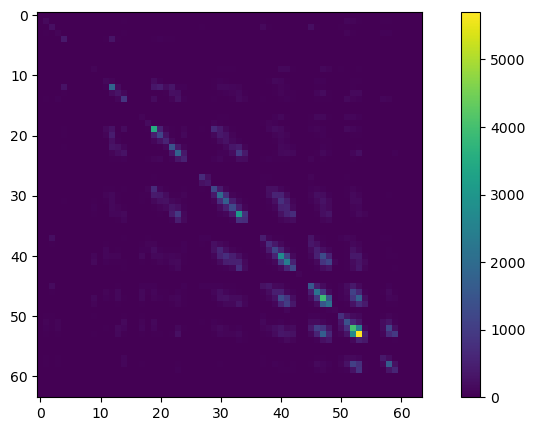

In [115]:
plt.imshow(a)
plt.colorbar()
plt.show()

In [121]:
# create a dataframe from a numpy array
adj = pd.DataFrame(a, columns=tessellation.tile_ID.values, index = tessellation.tile_ID.values)

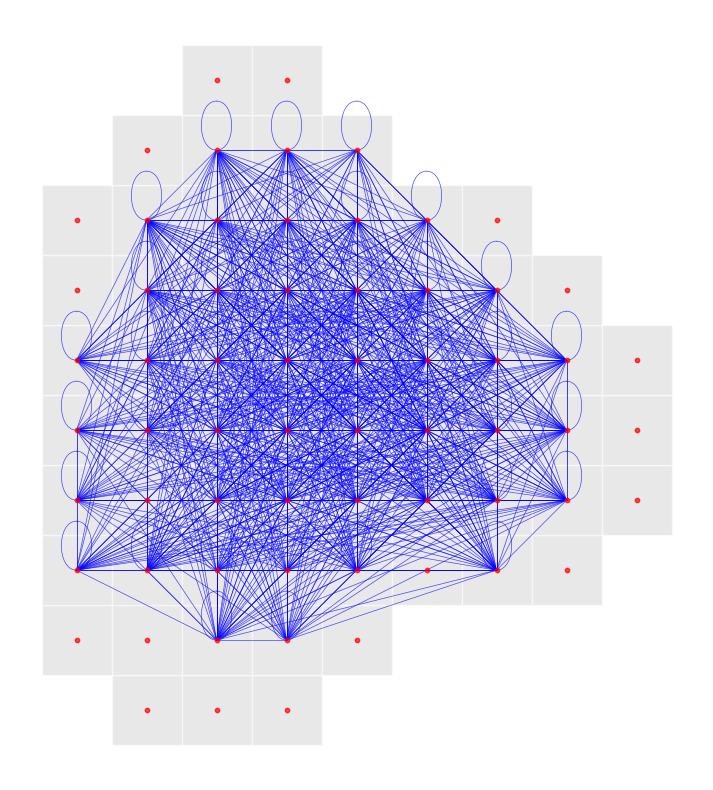

In [123]:
import networkx as nx
from shapely.geometry import Point

# Crear el grafo de NetworkX
G = nx.from_pandas_adjacency(adj)

# Crear posiciones para los nodos en base al centroide de cada tile
tile_centroids = tessellation.geometry.centroid
positions = {str(i): (centroid.x, centroid.y) for i, centroid in enumerate(tile_centroids)}

# Dibujar el mapa de fondo con los tiles
fig, ax = plt.subplots(figsize=(10, 10))
tessellation.plot(ax=ax, color='lightgrey', edgecolor='white', alpha=0.5)

# Dibujar la red de movilidad
nx.draw(G, pos=positions, ax=ax, node_size=10, node_color='red', edge_color='blue', width=0.5, alpha=0.7, with_labels=False)

plt.show()


### fdf plot

In [135]:
import folium
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from folium.plugins import BeautifyIcon

# Crear el mapa base de Folium centrado en Buenos Aires
mapa = folium.Map(location=[-34.61, -58.44], zoom_start=12, tiles='cartodbdark_matter')

# Definir los límites del área de teselación
min_x, min_y, max_x, max_y = -58.55, -34.7, -58.35, -34.52
tile_size = 0.01

# Crear las celdas de teselación
tiles = tessellation.geometry
# x_coords = np.arange(min_x, max_x, tile_size)
# y_coords = np.arange(min_y, max_y, tile_size)

# for x in tessellation:
#     # for y in y_coords:
#     tile = Polygon([(x, y), (x + tile_size, y), (x + tile_size, y + tile_size), (x, y + tile_size)])
#     tiles.append(tile)

# Añadir los tiles al mapa de Folium
for tile in tiles:
    folium.Polygon(locations=[(point[1], point[0]) for point in tile.exterior.coords],
                   color='gray', weight=0.8, fill=True, fill_opacity=0.01).add_to(mapa)

# Asumimos que ya tenemos una matriz de adyacencia 'adjacency_matrix' creada previamente
G = nx.from_pandas_adjacency(adj)

# Crear posiciones para los nodos en base al centroide de cada tile
tile_centroids = tessellation.geometry.centroid
positions = {str(i): (centroid.y, centroid.x) for i, centroid in enumerate(tile_centroids)}

# Añadir nodos al mapa como marcadores en cada tile
# for idx, (tile_id, coord) in enumerate(positions.items()):
#     folium.Marker(
#       location=coord,
#       icon=folium.Icon(color='red', icon='circle', prefix='fa')
#     ).add_to(mapa)

# Añadir las aristas con arqueamiento y grosor dependiente del flujo
for u, v, data in G.edges(data=True):
    # Datos de las coordenadas de los nodos origen y destino
    start = positions[u]
    end = positions[v]
    lat_start, lon_start = start
    lat_end, lon_end = end

    # Arqueamiento: calcular puntos intermedios para una línea curva
    midpoint_lat = (lat_start + lat_end) / 2 + 0.001  # Añadir un pequeño arqueo en latitud
    midpoint_lon = (lon_start + lon_end) / 2 + 0.001  # Añadir un pequeño arqueo en longitud
    if(start == end):
        midpoint_lat = lat_start
        midpoint_lon = lon_start
    # Coordenadas para la línea arqueada
    points = [(lat_start, lon_start), (midpoint_lat, midpoint_lon), (lat_end, lon_end)]
    # Grosor proporcional al flujo entre los tiles (valores de la matriz de adyacencia)
    weight = data['weight'] / adj.values.max() * 10  # Ajustar según escala deseada

    folium.PolyLine(
        locations=points,
        color='red',
        weight=weight,
        opacity=0.9
    ).add_to(mapa)

# Mostrar el mapa
# mapa.save("red_movilidad.html")
mapa


In [151]:
import folium
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from folium.plugins import BeautifyIcon

# Crear el mapa base de Folium centrado en Buenos Aires
mapa = folium.Map(location=[-34.61, -58.44], zoom_start=12, tiles='cartodbpositron')

# Definir los límites del área de teselación
min_x, min_y, max_x, max_y = -58.55, -34.7, -58.35, -34.52
tile_size = 0.01

# Crear las celdas de teselación
tiles = tessellation.geometry
# x_coords = np.arange(min_x, max_x, tile_size)
# y_coords = np.arange(min_y, max_y, tile_size)

# for x in tessellation:
#     # for y in y_coords:
#     tile = Polygon([(x, y), (x + tile_size, y), (x + tile_size, y + tile_size), (x, y + tile_size)])
#     tiles.append(tile)

# Añadir los tiles al mapa de Folium
for tile in tiles:
    folium.Polygon(locations=[(point[1], point[0]) for point in tile.exterior.coords],
                   color='gray', weight=0.8, fill=True, fill_opacity=0.1).add_to(mapa)

# Asumimos que ya tenemos una matriz de adyacencia 'adjacency_matrix' creada previamente
G = nx.from_pandas_adjacency(adj)

# Crear posiciones para los nodos en base al centroide de cada tile
# tile_centroids = tessellation.geometry.centroid
# positions = {str(i): (centroid.y, centroid.x) for i, centroid in enumerate(tile_centroids)}
stations_or = df[['lat_estacion_origen', 'long_estacion_origen']].drop_duplicates().rename(columns={'lat_estacion_origen':'lat', 'long_estacion_origen':'lon'})
stations_de = df[['lat_estacion_destino', 'long_estacion_destino']].drop_duplicates().rename(columns={'lat_estacion_destino':'lat', 'long_estacion_destino':'lon'})
stations = pd.concat([stations_or, stations_de]).drop_duplicates().dropna()

positions = {str(i): (row['lat'], row['lon']) for i, row in stations.iterrows()}

# Añadir nodos al mapa como marcadores en cada tile
for idx, (tile_id, coord) in enumerate(positions.items()):
    folium.CircleMarker(
      location=coord,
      radius=5,
      color='red',
      fill=True,
      fill_color='red',
      fill_opacity=0.6
    ).add_to(mapa)

# Mostrar el mapa
# mapa.save("red_movilidad.html")
mapa


In [149]:
stations

,lat,lon
0,-34.615638,-58.389692
1,-34.601761,-58.415459
2,-34.603162,-58.439709
3,-34.598222,-58.421705
5,-34.604635,-58.415759
...,...,...
15360489,-34.590648,-58.428899
15541908,-34.614787,-58.511672
15547315,-34.612296,-58.443295
15548090,-34.574424,-58.496232


In [141]:
positions = {str(i): (row['lat_estacion_origen'], row['long_estacion_origen']) for i, row in stations.iterrows()}
positions

{'0': (nan, nan),
 '1': (nan, nan),
 '2': (nan, nan),
 '3': (nan, nan),
 '5': (nan, nan),
 '7': (nan, nan),
 '8': (nan, nan),
 '11': (nan, nan),
 '12': (nan, nan),
 '13': (nan, nan),
 '14': (nan, nan),
 '15': (nan, nan),
 '16': (-34.6156376341942, -58.3896919074047),
 '17': (-34.6107824192457, -58.3735574617984),
 '19': (nan, nan),
 '21': (nan, nan),
 '22': (nan, nan),
 '23': (-34.6107962769337, -58.433506016027),
 '24': (-34.6199404395595, -58.3742180079119),
 '25': (nan, nan),
 '28': (nan, nan),
 '29': (-34.6221944542981, -58.4077875519753),
 '31': (nan, nan),
 '32': (nan, nan),
 '34': (nan, nan),
 '36': (nan, nan),
 '37': (nan, nan),
 '38': (nan, nan),
 '39': (nan, nan),
 '40': (-34.6010006869203, -58.3636035935707),
 '41': (nan, nan),
 '42': (nan, nan),
 '43': (-34.6117206752694, -58.3639690795297),
 '45': (nan, nan),
 '47': (-34.5902244780447, -58.411495316774),
 '52': (-34.5895207284602, -58.4160650218385),
 '54': (nan, nan),
 '55': (nan, nan),
 '56': (nan, nan),
 '59': (nan, nan